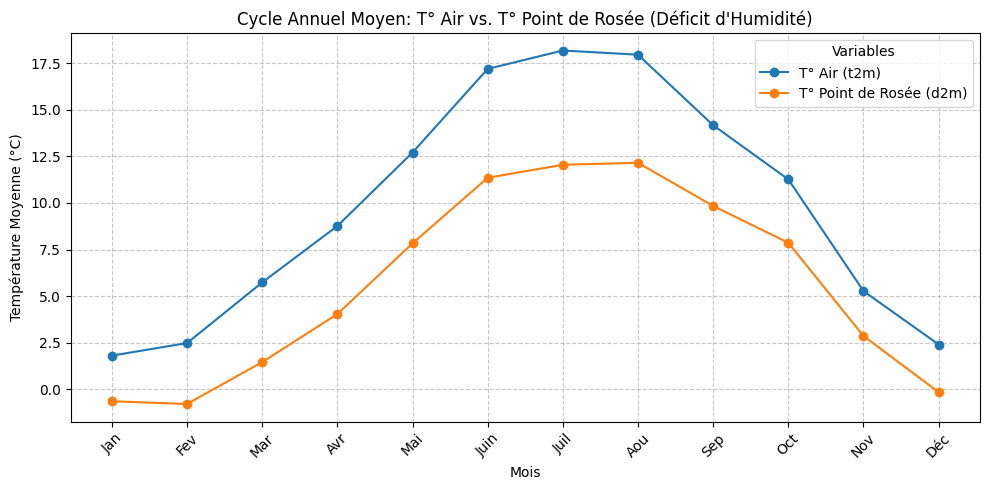

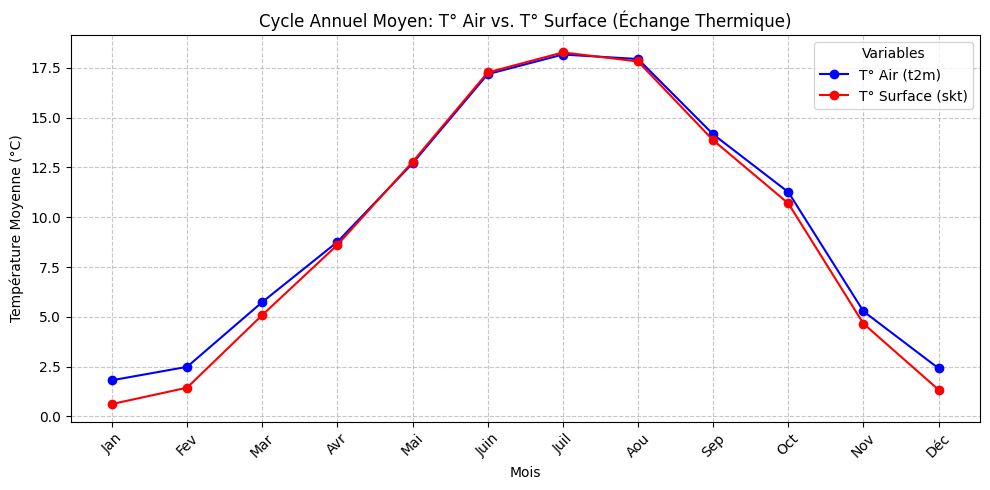

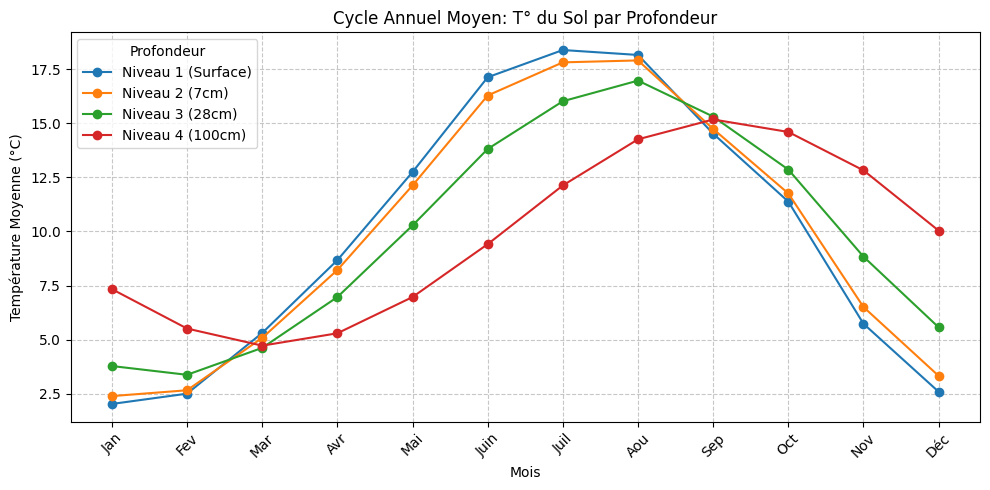

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# 1. CHARGEMENT, CONVERSION ET CORRECTION DE L'INDEX (MODA file)
# ==============================================================================

# Liste complète des 7 features
variables_all = ['d2m', 't2m', 'skt', 'stl1', 'stl2', 'stl3', 'stl4']

try:
    # 1.1 Chargement du fichier MODA (Moyenne Mensuelle)
    ds_moda = xr.open_dataset(r"C:\Users\ZEJLI\Projet 5A\bdd_temperature\data_stream-moda.nc")

    
    # 1.2 Calcul de la moyenne spatiale et Conversion en Celsius
    spatial_mean = ds_moda.mean(dim=['latitude', 'longitude'])
    spatial_mean_C = xr.Dataset()
    for var in variables_all:
        spatial_mean_C[f'{var}_C'] = spatial_mean[var] - 273.15
        
    df_temp_celsius = spatial_mean_C.to_dataframe()
    df_temp_celsius = df_temp_celsius.drop(columns=['number', 'expver'], errors='ignore')

    # 2. CORRECTION CRUCIALE DE L'INDEX TEMPOREL (Généralisée)
    # 2.1 Promote l'index (non nommé) en colonne
    df_temp_celsius = df_temp_celsius.reset_index() 
    
    # 2.2 Identifier dynamiquement la colonne de temps (première colonne)
    time_column_name = df_temp_celsius.columns[0] 
    
    # 2.3 Convertir cette colonne en Datetime et la renommer 'time'
    df_temp_celsius['time'] = pd.to_datetime(df_temp_celsius[time_column_name])
    df_temp_celsius = df_temp_celsius.drop(columns=[time_column_name], errors='ignore')
    
    # 2.4 Rétablir l'index 'time'
    df_temp_celsius = df_temp_celsius.set_index('time')
    
    # 2.5 Ajouter la colonne mois pour le regroupement
    df_temp_celsius['month'] = df_temp_celsius.index.month

except Exception as e:
    print(f"Erreur fatale lors de la préparation des données: {e}")
    print("Veuillez vérifier que les 7 variables sont disponibles et que 'xarray' est installé.")
    raise e


# ==============================================================================
# 2. CALCUL DU CYCLE ANNUEL MOYEN (Moyenne Mensuelle sur 8 ans)
# ==============================================================================

# Calcul de la moyenne pour chaque mois sur l'ensemble de la période (2000-2007)
mean_cycle = df_temp_celsius.groupby('month')[[f'{v}_C' for v in variables_all]].mean()

# Noms des mois pour l'axe X
month_names = ['Jan', 'Fev', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Aou', 'Sep', 'Oct', 'Nov', 'Déc']


# ==============================================================================
# 3. VISUALISATION PAR GROUPE DE FEATURE (3 PLOTS)
# ==============================================================================

# --- PLOT 1: TEMPÉRATURES AIR ET HUMIDITÉ (D2M vs T2M) ---
plt.figure(figsize=(10, 5))
mean_cycle[['t2m_C', 'd2m_C']].plot(kind='line', ax=plt.gca(), marker='o')
plt.title("Cycle Annuel Moyen: T° Air vs. T° Point de Rosée (Déficit d'Humidité)")
plt.xlabel("Mois")
plt.ylabel("Température Moyenne (°C)")
plt.xticks(ticks=mean_cycle.index, labels=month_names, rotation=45)
plt.legend(title='Variables', labels=["T° Air (t2m)", "T° Point de Rosée (d2m)"])
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# --- PLOT 2: TEMPÉRATURES AIR ET SURFACE (SKT vs T2M) ---
plt.figure(figsize=(10, 5))
mean_cycle[['t2m_C', 'skt_C']].plot(kind='line', ax=plt.gca(), marker='o', color=['blue', 'red'])
plt.title("Cycle Annuel Moyen: T° Air vs. T° Surface (Échange Thermique)")
plt.xlabel("Mois")
plt.ylabel("Température Moyenne (°C)")
plt.xticks(ticks=mean_cycle.index, labels=month_names, rotation=45)
plt.legend(title='Variables', labels=["T° Air (t2m)", "T° Surface (skt)"])
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# --- PLOT 3: PROFONDEUR DU SOL (STL1 à STL4) ---
soil_vars = ['stl1_C', 'stl2_C', 'stl3_C', 'stl4_C']
plt.figure(figsize=(10, 5))
mean_cycle[soil_vars].plot(kind='line', ax=plt.gca(), marker='o')
plt.title("Cycle Annuel Moyen: T° du Sol par Profondeur")
plt.xlabel("Mois")
plt.ylabel("Température Moyenne (°C)")
plt.xticks(ticks=mean_cycle.index, labels=month_names, rotation=45)
plt.legend(title='Profondeur', labels=['Niveau 1 (Surface)', 'Niveau 2 (7cm)', 'Niveau 3 (28cm)', 'Niveau 4 (100cm)'])
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()